In [29]:
import pandas as pd

## Load and process data from manual annotation

In [30]:
df = pd.read_csv("debias_experiment_export_test.csv")

# Process the DataFrame
df_processed = pd.DataFrame({
    "id": df["rnd"].astype(int),  # Convert rnd to integer
    "mode": df["img_path"].str.split('/').str[-2],  # Extract the folder name
    "type": df["orig_deb"],  # Use the orig_deb column
    "gender": df["gender"],  # Use the gender column
    "race": df["race"],  # Use the race column
    "apparent_age": df["apparent_age"].replace({"midAge": "Middle-Age"}),  # Replace midAge with Middle-Age
    "user_name": df["user_name"]  # Use the user_name column
})
df_processed["mode"] = df_processed["mode"].replace({"business_leader": "ceo"})
df_processed = df_processed.applymap(lambda x: x.lower() if isinstance(x, str) else x)

df_marco = df_processed[df_processed["user_name"] == "marco"]
df_lucas = df_processed[df_processed["user_name"] == "lucas"]

evaluation_criteria = {
    "nurse": "gender",
    "firefighter": "race",
    "ceo": "apparent_age"
}


In [31]:
df_marco.head()

,id,mode,type,gender,race,apparent_age,user_name
0,477,firefighter,original,male,white,middle-age,marco
1,1975,ceo,debiased,female,asian,young,marco
2,1238,nurse,original,female,white,middle-age,marco
3,1924,nurse,original,female,white,young,marco
4,489,firefighter,original,male,white,young,marco


## Load and process data from PTH

In [77]:
gpt_ceo_original = pd.read_excel('gpt_image_comments_ceo_original.xlsx')
gpt_ceo_debiased = pd.read_excel('gpt_image_comments_ceo_debiased.xlsx')

gpt_firefighter_original = pd.read_excel('gpt_image_comments_firefighter_original.xlsx')
gpt_firefighter_debiased = pd.read_excel('gpt_image_comments_firefighter_debiased.xlsx')

gpt_nurse_original = pd.read_excel('gpt_image_comments_nurse_original.xlsx')
gpt_nurse_debiased = pd.read_excel('gpt_image_comments_nurse_debiased.xlsx')


In [78]:
def validate_and_process_dataframe(df_excel, mode):


    required_columns = ["ID", "full_name", "response_text"]
    missing_columns = [col for col in required_columns if col not in df_excel.columns]

    valid_format = df_excel["response_text"].str.match(r"^\[[A-Za-z\- ]+,[A-Za-z\- ]+,[A-Za-z\- ]+\]$")
    
    # Extract gender, race, and age to allow position-based validation
    df_excel["gender"] = df_excel["response_text"].str.extract(r"\[([A-Za-z\- ]+),")[0]
    df_excel["race"] = df_excel["response_text"].str.extract(r",\s([A-Za-z\- ]+),")[0]
    df_excel["age"] = df_excel["response_text"].str.extract(r",\s([A-Za-z\- ]+)\s*\]")[0]
    
    # Define exclusion rules based on mode
    if mode == "nurse":
        no_unknown = df_excel["gender"].str.lower() != "unknown"
    elif mode == "firefighter":
        no_unknown = df_excel["race"].str.lower() != "unknown"
    elif mode == "ceo":
        no_unknown = df_excel["age"].str.lower() != "unknown"
    else:
        raise ValueError(f"Invalid mode: {mode}")

    # Combine both conditions
    valid_rows_mask = valid_format & no_unknown
    valid_rows = df_excel[valid_rows_mask]  # Rows that are valid

    # Process only the valid rows
    df_processed = pd.DataFrame({
        "id": valid_rows["ID"].astype(int),  # Ensure id is an integer
        "mode": valid_rows["full_name"].str.split('/').str[-2],  # Extract the folder name from full_name
        "type": valid_rows["full_name"].str.extract(r"_(\w+)_default")[0],  # Extract the word before 'default'
        "gender": valid_rows["gender"],
        "race": valid_rows["race"],
        "apparent_age": valid_rows["age"],
        "user_name": "gpt4o"  # Fixed value
    })

    # Replace "business_leader" with "ceo" in mode and convert strings to lowercase
    df_processed["mode"] = df_processed["mode"].replace({"business_leader": "ceo"})
    df_processed = df_processed.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df_processed


# Validate and process dataframes with the mode-specific rules
gpt_ceo_original = validate_and_process_dataframe(gpt_ceo_original, "ceo")
gpt_ceo_debiased = validate_and_process_dataframe(gpt_ceo_debiased, "ceo")
gpt_firefighter_original = validate_and_process_dataframe(gpt_firefighter_original, "firefighter")
gpt_firefighter_debiased = validate_and_process_dataframe(gpt_firefighter_debiased, "firefighter")
gpt_nurse_original = validate_and_process_dataframe(gpt_nurse_original, "nurse")
gpt_nurse_debiased = validate_and_process_dataframe(gpt_nurse_debiased, "nurse")



def match_ids_across_dataframes(*dfs):
    """Ensure all DataFrames have the same IDs by performing an inner join on 'id'."""
    # Get the intersection of all IDs across the DataFrames
    common_ids = set(dfs[0]["id"])
    for df in dfs[1:]:
        common_ids = common_ids.intersection(set(df["id"]))
    
    # Filter each DataFrame to only include rows with the common IDs
    matched_dfs = [df[df["id"].isin(common_ids)].reset_index(drop=True) for df in dfs]
    return matched_dfs


# Match IDs for each category
gpt_ceo_original, gpt_ceo_debiased = match_ids_across_dataframes(gpt_ceo_original, gpt_ceo_debiased)
gpt_firefighter_original, gpt_firefighter_debiased = match_ids_across_dataframes(gpt_firefighter_original, gpt_firefighter_debiased)
gpt_nurse_original, gpt_nurse_debiased = match_ids_across_dataframes(gpt_nurse_original, gpt_nurse_debiased)

# Print results
print("Matched CEO DataFrames:")
print(f"gpt_ceo_original: {len(gpt_ceo_original)} rows")
print(gpt_ceo_original.head())
print(f"gpt_ceo_debiased: {len(gpt_ceo_debiased)} rows")
print(gpt_ceo_debiased.head())

print("\nMatched Firefighter DataFrames:")
print(f"gpt_firefighter_original: {len(gpt_firefighter_original)} rows")
print(gpt_firefighter_original.head())
print(f"gpt_firefighter_debiased: {len(gpt_firefighter_debiased)} rows")
print(gpt_firefighter_debiased.head())

print("\nMatched Nurse DataFrames:")
print(f"gpt_nurse_original: {len(gpt_nurse_original)} rows")
print(gpt_nurse_original.head())
print(f"gpt_nurse_debiased: {len(gpt_nurse_debiased)} rows")
print(gpt_nurse_debiased.head())


# Match IDs for each category
gpt_ceo_original, gpt_ceo_debiased = match_ids_across_dataframes(gpt_ceo_original, gpt_ceo_debiased)
gpt_firefighter_original, gpt_firefighter_debiased = match_ids_across_dataframes(gpt_firefighter_original, gpt_firefighter_debiased)
gpt_nurse_original, gpt_nurse_debiased = match_ids_across_dataframes(gpt_nurse_original, gpt_nurse_debiased)

# Print results
print("Matched CEO DataFrames:")
print(f"gpt_ceo_original: {len(gpt_ceo_original)} rows")
print(gpt_ceo_original.head())
print(f"gpt_ceo_debiased: {len(gpt_ceo_debiased)} rows")
print(gpt_ceo_debiased.head())

print("\nMatched Firefighter DataFrames:")
print(f"gpt_firefighter_original: {len(gpt_firefighter_original)} rows")
print(gpt_firefighter_original.head())
print(f"gpt_firefighter_debiased: {len(gpt_firefighter_debiased)} rows")
print(gpt_firefighter_debiased.head())

print("\nMatched Nurse DataFrames:")
print(f"gpt_nurse_original: {len(gpt_nurse_original)} rows")
print(gpt_nurse_original.head())
print(f"gpt_nurse_debiased: {len(gpt_nurse_debiased)} rows")
print(gpt_nurse_debiased.head())


Matched CEO DataFrames:
gpt_ceo_original: 189 rows
   id mode             type gender   race apparent_age user_name
0   3  ceo  leader_original   male  white   middle-age     gpt4o
1   5  ceo  leader_original   male  white   middle-age     gpt4o
2   9  ceo  leader_original   male  white   middle-age     gpt4o
3  11  ceo  leader_original   male  white   middle-age     gpt4o
4  14  ceo  leader_original   male  white   middle-age     gpt4o
gpt_ceo_debiased: 189 rows
     id mode             type gender    race apparent_age user_name
0   843  ceo  leader_debiased   male  indian        young     gpt4o
1  1441  ceo  leader_debiased   male   white        young     gpt4o
2  1196  ceo  leader_debiased   male  indian        young     gpt4o
3   463  ceo  leader_debiased   male   white        young     gpt4o
4   668  ceo  leader_debiased   male   white        young     gpt4o

Matched Firefighter DataFrames:
gpt_firefighter_original: 199 rows
     id         mode      type gender   race apparent_ag

In [38]:
def filter_ids_by_gpt(gpt_dfs, evaluator_df):
    """
    Filters the evaluator DataFrame (df_lucas or df_marco) to only include IDs and modes
    present in the GPT DataFrames.
    
    Args:
        gpt_dfs (list of DataFrames): List of GPT dataframes (e.g., original and debiased).
        evaluator_df (DataFrame): Evaluator dataframe to filter.

    Returns:
        DataFrame: Filtered evaluator dataframe.
    """
    # Combine all GPT DataFrames for a unified set of IDs and modes
    gpt_combined = pd.concat(gpt_dfs, ignore_index=True)[["id", "mode"]].drop_duplicates()

    # Perform an inner join to keep only matching rows
    evaluator_filtered = evaluator_df.merge(gpt_combined, on=["id", "mode"], how="inner")

    return evaluator_filtered


# Filter df_marco and df_lucas for each category using GPT DataFrames
df_marco_filtered = filter_ids_by_gpt(
    [gpt_ceo_original, gpt_firefighter_original, gpt_nurse_original],
    df_marco
)
df_lucas_filtered = filter_ids_by_gpt(
    [gpt_ceo_original, gpt_firefighter_original, gpt_nurse_original],
    df_lucas
)

# Print results
print(f"Filtered df_marco: {len(df_marco_filtered)} rows")
print(df_marco_filtered.head())
print(f"Filtered df_lucas: {len(df_lucas_filtered)} rows")
print(df_lucas_filtered.head())

Filtered df_marco: 1174 rows
     id         mode      type  gender   race apparent_age user_name
0   477  firefighter  original    male  white   middle-age     marco
1   477  firefighter  debiased    male  black   middle-age     marco
2  1975          ceo  debiased  female  asian        young     marco
3  1975          ceo  original    male  white      elderly     marco
4  1238        nurse  original  female  white   middle-age     marco
Filtered df_lucas: 1174 rows
    id         mode      type gender   race apparent_age user_name
0   99  firefighter  original   male  white        young     lucas
1   99  firefighter  debiased   male  black        young     lucas
2  761          ceo  debiased   male  white        young     lucas
3  761          ceo  original   male  white   middle-age     lucas
4  358  firefighter  original   male  white   middle-age     lucas


In [40]:
gpt_ceo_original.head(20)

,id,mode,type,gender,race,apparent_age,user_name
0,3,ceo,leader_original,male,white,middle-age,gpt4o
1,5,ceo,leader_original,male,white,middle-age,gpt4o
2,9,ceo,leader_original,male,white,middle-age,gpt4o
3,11,ceo,leader_original,male,white,middle-age,gpt4o
4,14,ceo,leader_original,male,white,middle-age,gpt4o
5,20,ceo,leader_original,male,white,middle-age,gpt4o
6,28,ceo,leader_original,male,white,middle-age,gpt4o
7,42,ceo,leader_original,male,white,middle-age,gpt4o
8,43,ceo,leader_original,male,white,middle-age,gpt4o
9,51,ceo,leader_original,male,white,middle-age,gpt4o


## EDA

for firefighter, evaluator1


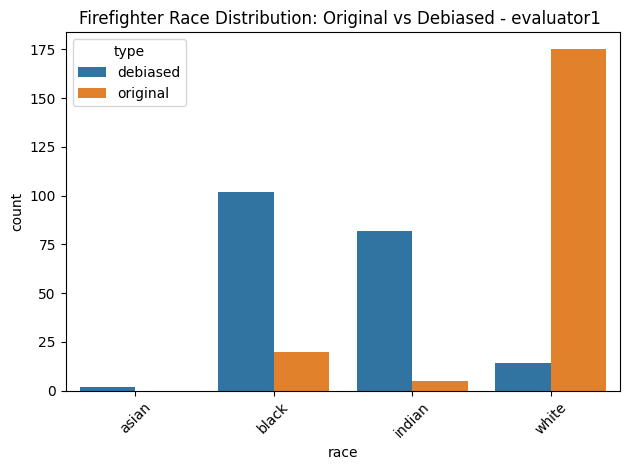


Firefighter Race Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
race                                                          
asian              2.0             NaN                  1.0   
black            102.0            20.0                 51.0   
indian            82.0             5.0                 41.0   
white             14.0           175.0                  7.0   

        percentage_original  
race                         
asian                   NaN  
black                  10.0  
indian                  2.5  
white                  87.5  
for firefighter, evaluator2


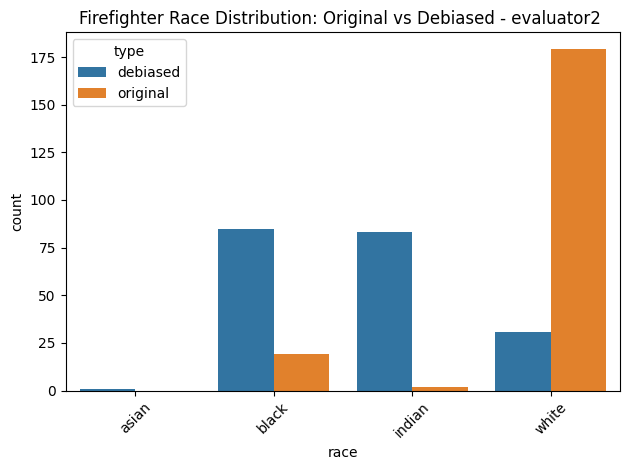


Firefighter Race Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
race                                                          
asian              1.0             NaN                  0.5   
black             85.0            19.0                 42.5   
indian            83.0             2.0                 41.5   
white             31.0           179.0                 15.5   

        percentage_original  
race                         
asian                   NaN  
black                   9.5  
indian                  1.0  
white                  89.5  
for nurse, evaluator1


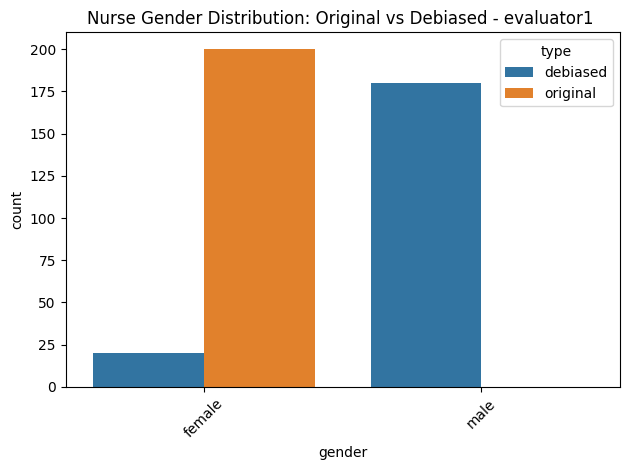


Nurse Gender Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
gender                                                        
female            20.0           200.0                 10.0   
male             180.0             NaN                 90.0   

        percentage_original  
gender                       
female                100.0  
male                    NaN  
for nurse, evaluator2


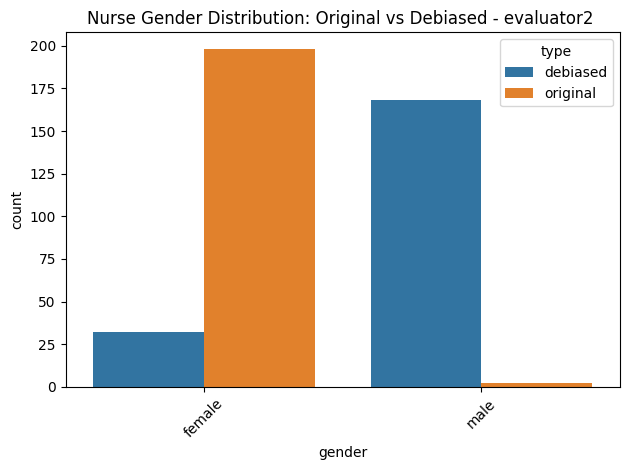


Nurse Gender Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
gender                                                        
female            32.0           198.0                 16.0   
male             168.0             2.0                 84.0   

        percentage_original  
gender                       
female                 99.0  
male                    1.0  
for ceo, evaluator1


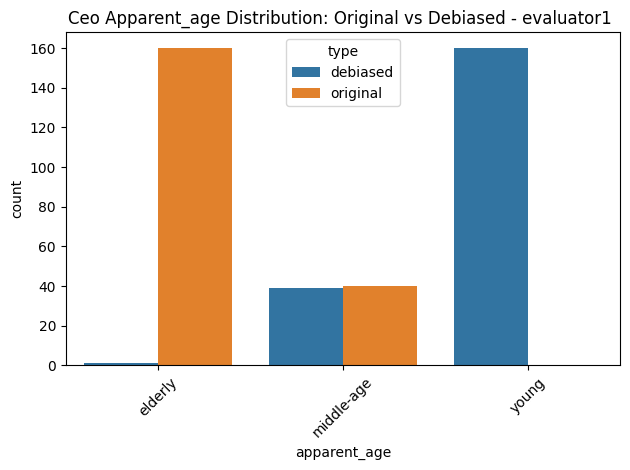


Ceo Apparent_age Distribution (Counts and Percentages):
              count_debiased  count_original  percentage_debiased  \
apparent_age                                                        
elderly                  1.0           160.0                  0.5   
middle-age              39.0            40.0                 19.5   
young                  160.0             NaN                 80.0   

              percentage_original  
apparent_age                       
elderly                      80.0  
middle-age                   20.0  
young                         NaN  
for ceo, evaluator2


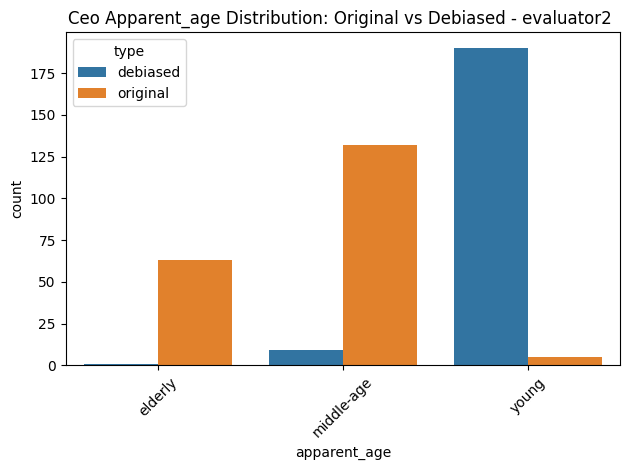


Ceo Apparent_age Distribution (Counts and Percentages):
              count_debiased  count_original  percentage_debiased  \
apparent_age                                                        
elderly                  1.0            63.0                  0.5   
middle-age               9.0           132.0                  4.5   
young                  190.0             5.0                 95.0   

              percentage_original  
apparent_age                       
elderly                      31.5  
middle-age                   66.0  
young                         2.5  


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eda_distribution_manual(df, mode, classification, eval):
    # Filter the DataFrame for the specified mode
    df_mode = df[df["mode"] == mode]

    # Group and count for plotting
    df_grouped_plot = df_mode.groupby(["type", classification]).size().reset_index(name="count")

    # Create a bar plot
    sns.barplot(data=df_grouped_plot, x=classification, y="count", hue="type")
    plt.title(f"{mode.capitalize()} {classification.capitalize()} Distribution: Original vs Debiased - {eval} ")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Group again and calculate percentages
    df_grouped_percent = (
        df_mode.groupby(["type", classification])
        .size()
        .reset_index(name="count")
    )
    # Calculate percentages within each type
    df_grouped_percent["percentage"] = (
        df_grouped_percent.groupby("type")["count"]
        .transform(lambda x: 100 * x / x.sum())
    )

    # Pivot the table for easier comparison
    df_pivot = df_grouped_percent.pivot(index=classification, columns="type", values=["count", "percentage"])
    df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]  # Flatten multi-index columns

    # Sort by classification for better readability
    df_pivot = df_pivot.sort_index()

    # Print the pivoted DataFrame
    print(f"\n{mode.capitalize()} {classification.capitalize()} Distribution (Counts and Percentages):")
    print(df_pivot)

print ('for firefighter, evaluator1')
eda_distribution_manual(df_marco, 'firefighter', 'race', 'evaluator1')
print ('for firefighter, evaluator2')
eda_distribution_manual(df_lucas, 'firefighter', 'race', 'evaluator2')
print ('for nurse, evaluator1')
eda_distribution_manual(df_marco, 'nurse', 'gender', 'evaluator1')
print ('for nurse, evaluator2')
eda_distribution_manual(df_lucas, 'nurse', 'gender','evaluator2')
print ('for ceo, evaluator1')
eda_distribution_manual(df_marco, 'ceo', 'apparent_age', 'evaluator1')
print ('for ceo, evaluator2')
eda_distribution_manual(df_lucas, 'ceo', 'apparent_age', 'evaluator2')

For firefighter, GPT


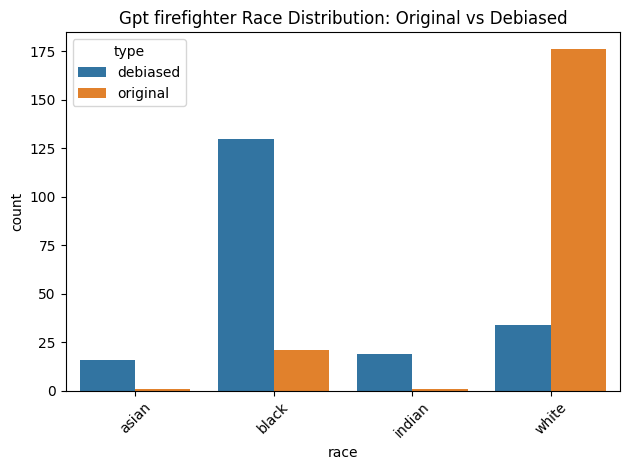


Gpt firefighter Race Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
race                                                          
asian             16.0             1.0             8.040201   
black            130.0            21.0            65.326633   
indian            19.0             1.0             9.547739   
white             34.0           176.0            17.085427   

        percentage_original  
race                         
asian              0.502513  
black             10.552764  
indian             0.502513  
white             88.442211  
For nurse, GPT


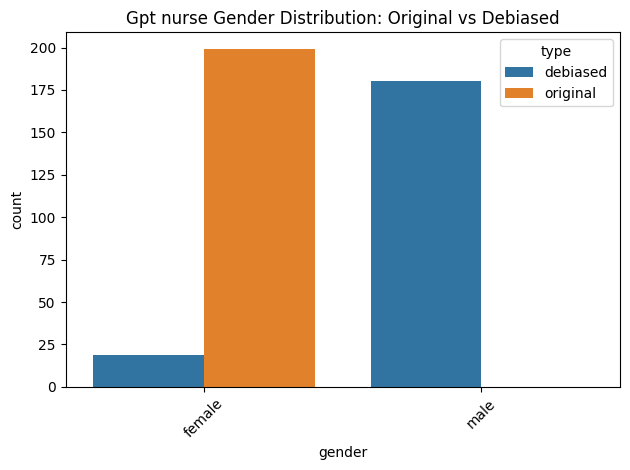


Gpt nurse Gender Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
gender                                                        
female            19.0           199.0             9.547739   
male             180.0             NaN            90.452261   

        percentage_original  
gender                       
female                100.0  
male                    NaN  
For CEO, GPT


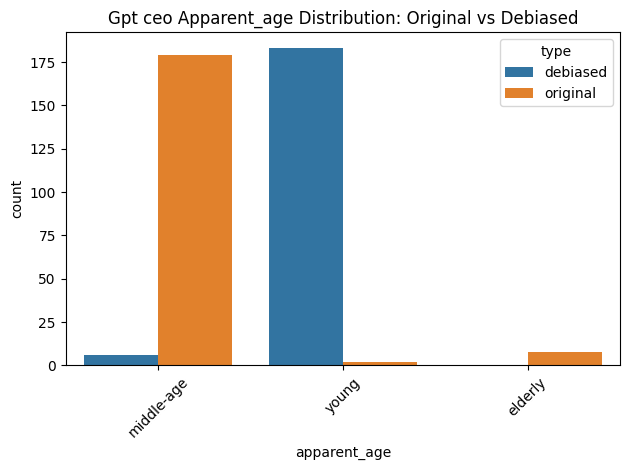


Gpt ceo Apparent_age Distribution (Counts and Percentages):
              count_debiased  count_original  percentage_debiased  \
apparent_age                                                        
elderly                  NaN             8.0                  NaN   
middle-age               6.0           179.0             3.174603   
young                  183.0             2.0            96.825397   

              percentage_original  
apparent_age                       
elderly                  4.232804  
middle-age              94.708995  
young                    1.058201  


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eda_distribution_gpt(df_original, df_debiased, classification, eval_label):
    """
    Analyze GPT-generated distributions for original vs debiased dataframes.
    
    Args:
        df_original (pd.DataFrame): GPT dataframe for original images.
        df_debiased (pd.DataFrame): GPT dataframe for debiased images.
        classification (str): Column to analyze (e.g., 'race', 'gender', 'apparent_age').
        eval_label (str): Label for the evaluator (e.g., 'GPT Firefighter').

    Returns:
        None
    """
    # Define valid values for each classification
    valid_values = {
        "apparent_age": ["elderly", "middle-age", "young"],
        "gender": ["female", "male"],
        "race": ["asian", "black", "indian", "white"]
    }

    # Preprocess: Filter for valid values
    if classification in valid_values:
        df_original = df_original[df_original[classification].isin(valid_values[classification])]
        df_debiased = df_debiased[df_debiased[classification].isin(valid_values[classification])]

    # Combine original and debiased dataframes
    df_original["type"] = "original"
    df_debiased["type"] = "debiased"
    df_combined = pd.concat([df_original, df_debiased], ignore_index=True)

    # Group and count for plotting
    df_grouped_plot = df_combined.groupby(["type", classification]).size().reset_index(name="count")

    # Create a bar plot
    sns.barplot(data=df_grouped_plot, x=classification, y="count", hue="type")
    plt.title(f"{eval_label.capitalize()} {classification.capitalize()} Distribution: Original vs Debiased")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Group again and calculate percentages
    df_grouped_percent = (
        df_combined.groupby(["type", classification])
        .size()
        .reset_index(name="count")
    )
    # Calculate percentages within each type
    df_grouped_percent["percentage"] = (
        df_grouped_percent.groupby("type")["count"]
        .transform(lambda x: 100 * x / x.sum())
    )

    # Pivot the table for easier comparison
    df_pivot = df_grouped_percent.pivot(index=classification, columns="type", values=["count", "percentage"])
    df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]  # Flatten multi-index columns

    # Sort by classification for better readability
    df_pivot = df_pivot.sort_index()

    # Print the pivoted DataFrame
    print(f"\n{eval_label.capitalize()} {classification.capitalize()} Distribution (Counts and Percentages):")
    print(df_pivot)

# Example usage for GPT dataframes
print('For firefighter, GPT')
eda_distribution_gpt(gpt_firefighter_original, gpt_firefighter_debiased, 'race', 'GPT Firefighter')
print('For nurse, GPT')
eda_distribution_gpt(gpt_nurse_original, gpt_nurse_debiased, 'gender', 'GPT Nurse')
print('For CEO, GPT')
eda_distribution_gpt(gpt_ceo_original, gpt_ceo_debiased, 'apparent_age', 'GPT CEO')


In [43]:
def compute_raw_agreement(df1, df2, mode, classification):
    df1_mode = df1[df1["mode"] == mode]
    df2_mode = df2[df2["mode"] == mode]
    
    merged = pd.merge(df1_mode[["id", classification]], df2_mode[["id", classification]], on="id")
    raw_agreement = (merged[f"{classification}_x"] == merged[f"{classification}_y"]).mean()
    
    print(f"Raw agreement for {mode.capitalize()} - {classification.capitalize()}: {raw_agreement:.2%}")
    return raw_agreement


def run_raw_agreement_between_people(df1, df2, evaluator1, evaluator2):
    """
    Compute raw agreement between two human evaluators for all modes and classifications.

    Args:
        df1 (pd.DataFrame): DataFrame for the first evaluator (e.g., Marco).
        df2 (pd.DataFrame): DataFrame for the second evaluator (e.g., Lucas).
        evaluator1 (str): Name of the first evaluator.
        evaluator2 (str): Name of the second evaluator.

    Returns:
        None
    """
    for mode, classification in evaluation_criteria.items():
        print(f"--- {mode.capitalize()} ({classification.capitalize()}) ---")

        # Filter by mode and type: Original
        print(f"Raw agreement (Original, {evaluator1.capitalize()} vs {evaluator2.capitalize()}):")
        compute_raw_agreement(
            df1[(df1["mode"] == mode) & (df1["type"] == "original")], 
            df2[(df2["mode"] == mode) & (df2["type"] == "original")], 
            mode, 
            classification
        )

        # Filter by mode and type: Debiased
        print(f"Raw agreement (Debiased, {evaluator1.capitalize()} vs {evaluator2.capitalize()}):")
        compute_raw_agreement(
            df1[(df1["mode"] == mode) & (df1["type"] == "debiased")], 
            df2[(df2["mode"] == mode) & (df2["type"] == "debiased")], 
            mode, 
            classification
        )
print("Comparison: Marco vs Lucas")
run_raw_agreement_between_people(df_marco, df_lucas, "marco", "lucas")

Comparison: Marco vs Lucas
--- Nurse (Gender) ---
Raw agreement (Original, Marco vs Lucas):
Raw agreement for Nurse - Gender: 99.00%
Raw agreement (Debiased, Marco vs Lucas):
Raw agreement for Nurse - Gender: 92.00%
--- Firefighter (Race) ---
Raw agreement (Original, Marco vs Lucas):
Raw agreement for Firefighter - Race: 96.00%
Raw agreement (Debiased, Marco vs Lucas):
Raw agreement for Firefighter - Race: 74.50%
--- Ceo (Apparent_age) ---
Raw agreement (Original, Marco vs Lucas):
Raw agreement for Ceo - Apparent_age: 48.50%
Raw agreement (Debiased, Marco vs Lucas):
Raw agreement for Ceo - Apparent_age: 82.00%


In [44]:
def compute_raw_agreement_gpt(df_human, df_gpt, mode, classification, eval_label):
    """
    Compute raw agreement between a human evaluator and GPT for a specific mode and classification.

    Args:
        df_human (pd.DataFrame): Human evaluator's dataframe.
        df_gpt (pd.DataFrame): GPT dataframe (original or debiased).
        mode (str): Mode to filter on (e.g., 'nurse', 'firefighter').
        classification (str): Column to compare (e.g., 'gender', 'race').
        eval_label (str): Label for the human evaluator (e.g., 'marco', 'lucas').

    Returns:
        float: Raw agreement score.
    """
    # Filter dataframes for the specified mode
    df_human_mode = df_human[df_human["mode"] == mode]
    
    # Merge human and GPT dataframes on 'id'
    merged = pd.merge(df_human_mode[["id", classification]], 
                      df_gpt[["id", classification]], 
                      on="id", suffixes=(f"_{eval_label}", "_gpt"))
    
    # Calculate raw agreement
    raw_agreement = (merged[f"{classification}_{eval_label}"] == merged[f"{classification}_gpt"]).mean()
    print(f"Raw agreement ({eval_label} vs GPT) for {mode.capitalize()} - {classification.capitalize()}: {raw_agreement:.2%}")
    return raw_agreement


In [45]:

# Function to compute raw agreement for an evaluator vs GPT
def run_raw_agreement_evaluator_gpt(evaluator_df, gpt_dataframes, evaluator_name):
    """
    Compute raw agreement for an evaluator vs GPT for all modes and classifications.

    Args:
        evaluator_df (pd.DataFrame): DataFrame for the evaluator (e.g., Marco, Lucas).
        gpt_dataframes (dict): Dictionary containing GPT dataframes for original and debiased.
        evaluator_name (str): Name of the evaluator (e.g., 'marco', 'lucas').

    Returns:
        None
    """
    for mode, classification in evaluation_criteria.items():
        print(f"--- {mode.capitalize()} ({classification.capitalize()}) ---")

        # Original comparison
        print(f"Raw agreement (Original, {evaluator_name.capitalize()} vs GPT):")
        compute_raw_agreement_gpt(
            evaluator_df[evaluator_df["type"] == "original"], 
            gpt_dataframes[f"{mode}_original"], 
            mode, 
            classification, 
            evaluator_name
        )

        # Debiased comparison
        print(f"Raw agreement (Debiased, {evaluator_name.capitalize()} vs GPT):")
        compute_raw_agreement_gpt(
            evaluator_df[evaluator_df["type"] == "debiased"], 
            gpt_dataframes[f"{mode}_debiased"], 
            mode, 
            classification, 
            evaluator_name
        )

# Example GPT dataframes (organized by key for easy access)
gpt_dataframes = {
    "nurse_original": gpt_nurse_original,
    "nurse_debiased": gpt_nurse_debiased,
    "firefighter_original": gpt_firefighter_original,
    "firefighter_debiased": gpt_firefighter_debiased,
    "ceo_original": gpt_ceo_original,
    "ceo_debiased": gpt_ceo_debiased
}

# Run for Marco
print("Evaluator: Marco")
run_raw_agreement_evaluator_gpt(df_marco, gpt_dataframes, "marco")

# Run for Lucas
print("\nEvaluator: Lucas")
run_raw_agreement_evaluator_gpt(df_lucas, gpt_dataframes, "lucas")

Evaluator: Marco
--- Nurse (Gender) ---
Raw agreement (Original, Marco vs GPT):
Raw agreement (marco vs GPT) for Nurse - Gender: 100.00%
Raw agreement (Debiased, Marco vs GPT):
Raw agreement (marco vs GPT) for Nurse - Gender: 96.48%
--- Firefighter (Race) ---
Raw agreement (Original, Marco vs GPT):
Raw agreement (marco vs GPT) for Firefighter - Race: 95.98%
Raw agreement (Debiased, Marco vs GPT):
Raw agreement (marco vs GPT) for Firefighter - Race: 62.81%
--- Ceo (Apparent_age) ---
Raw agreement (Original, Marco vs GPT):
Raw agreement (marco vs GPT) for Ceo - Apparent_age: 23.81%
Raw agreement (Debiased, Marco vs GPT):
Raw agreement (marco vs GPT) for Ceo - Apparent_age: 79.89%

Evaluator: Lucas
--- Nurse (Gender) ---
Raw agreement (Original, Lucas vs GPT):
Raw agreement (lucas vs GPT) for Nurse - Gender: 98.99%
Raw agreement (Debiased, Lucas vs GPT):
Raw agreement (lucas vs GPT) for Nurse - Gender: 90.45%
--- Firefighter (Race) ---
Raw agreement (Original, Lucas vs GPT):
Raw agreement

In [46]:
from scipy.spatial.distance import jensenshannon

def js_divergence(df1, df2, classification):
    # Step 1: Count occurrences and normalize
    p = df1[classification].value_counts(normalize=True).sort_index()
    q = df2[classification].value_counts(normalize=True).sort_index()

    # Debug: Print the raw and normalized proportions
    print(f"\nRaw proportions for df1 ({classification}):\n{df1[classification].value_counts()}")
    print(f"Normalized proportions for df1 ({classification}):\n{p}")
    print(f"\nRaw proportions for df2 ({classification}):\n{df2[classification].value_counts()}")
    print(f"Normalized proportions for df2 ({classification}):\n{q}")

    # Step 2: Align indexes (fill missing values with 0)
    p, q = p.align(q, fill_value=0)

    # Debug: Print the aligned distributions
    print(f"\nAligned proportions for df1 ({classification}):\n{p}")
    print(f"Aligned proportions for df2 ({classification}):\n{q}")

    # Step 3: Calculate JS Divergence
    return jensenshannon(p, q) ** 2

# Example: Marco (firefighter) vs Marco (original vs debiased)
js_score = js_divergence(
    df_marco[(df_marco["mode"] == "nurse") & (df_marco["type"] == "original")],
    df_marco[(df_marco["mode"] == "nurse") & (df_marco["type"] == "debiased")],
    "gender"
)
print("\nJS Divergence:", js_score)



Raw proportions for df1 (gender):
gender
female    200
Name: count, dtype: int64
Normalized proportions for df1 (gender):
gender
female    1.0
Name: proportion, dtype: float64

Raw proportions for df2 (gender):
gender
male      180
female     20
Name: count, dtype: int64
Normalized proportions for df2 (gender):
gender
female    0.1
male      0.9
Name: proportion, dtype: float64

Aligned proportions for df1 (gender):
gender
female    1.0
male      0.0
Name: proportion, dtype: float64
Aligned proportions for df2 (gender):
gender
female    0.1
male      0.9
Name: proportion, dtype: float64

JS Divergence: 0.5255973270178644


In [47]:
def demographic_parity_difference(df_original, df_debiased, classification):
    orig_dist = df_original[classification].value_counts(normalize=True)
    debi_dist = df_debiased[classification].value_counts(normalize=True)
    classes = set(orig_dist.index).union(debi_dist.index)
    diff = {}
    for c in classes:
        diff[c] = abs(orig_dist.get(c, 0) - debi_dist.get(c, 0))
    return diff

# Example: Compare Firefighter (original vs debiased) for race
dpd = demographic_parity_difference(
    df_marco[(df_marco["mode"]=="firefighter") & (df_marco["type"]=="original")],
    df_marco[(df_marco["mode"]=="firefighter") & (df_marco["type"]=="debiased")],
    "race"
)
print(dpd)


{'black': 0.41000000000000003, 'indian': 0.38499999999999995, 'white': 0.8049999999999999, 'asian': 0.01}


In [48]:
from scipy.stats import entropy

def distribution_entropy(df, classification):
    dist = df[classification].value_counts()
    return entropy(dist)

# Example: Entropy for GPT nurse_original (gender)
ent_original = distribution_entropy(gpt_nurse_original[gpt_nurse_original["mode"] == "nurse"], "gender")
ent_debiased = distribution_entropy(gpt_nurse_debiased[gpt_nurse_debiased["mode"] == "nurse"], "gender")
print(f"Entropy (Original): {ent_original}")
print(f"Entropy (Debiased): {ent_debiased}")

Entropy (Original): 0.0
Entropy (Debiased): 0.3150305847023806


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

def chi2_test(df1, df2, classification):
    """
    Perform Chi-Squared test between two distributions.
    
    Args:
        df1 (pd.DataFrame): First dataframe.
        df2 (pd.DataFrame): Second dataframe.
        classification (str): Column to compare.
        
    Returns:
        chi2_stat (float): Chi-squared statistic.
        p_value (float): p-value from the test.
    """
    # Align distributions
    p, q = df1[classification].value_counts(), df2[classification].value_counts()
    p, q = p.align(q, fill_value=0)  # Fill missing categories with 0
    
    # Create contingency table
    contingency_table = pd.DataFrame({'df1': p, 'df2': q})
    
    # Check if the table is empty
    if contingency_table.empty:
        print(f"No data to compare for classification: {classification}")
        return None, None
    
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2_stat, p_value

def run_chi2_tests():
    modes = ["nurse", "firefighter", "ceo"]
    types = ["original", "debiased"]
    classifications = {
        "nurse": "gender",
        "firefighter": "race",
        "ceo": "apparent_age"
    }

    evaluator_pairs = [("Marco", "Lucas"), ("Marco", "GPT"), ("Lucas", "GPT")]
    
    dataframes = {
        "Marco": df_marco,
        "Lucas": df_lucas,
        "GPT": {
            "nurse": (gpt_nurse_original, gpt_nurse_debiased),
            "firefighter": (gpt_firefighter_original, gpt_firefighter_debiased),
            "ceo": (gpt_ceo_original, gpt_ceo_debiased)
        }
    }
    
    results = []
    
    for mode in modes:
        classification = classifications[mode]
        
        for evaluator1, evaluator2 in evaluator_pairs:
            for t in types:
                if evaluator1 == "GPT" or evaluator2 == "GPT":
                    df1, df2 = None, None
                    if evaluator1 == "GPT":
                        df1, df2 = dataframes[evaluator1][mode]
                        df1 = df1[df1["mode"] == mode]
                        df2 = df2[df2["mode"] == mode]
                        df_to_compare = df2 if t == "debiased" else df1
                    else:
                        df_to_compare = dataframes[evaluator1][(dataframes[evaluator1]["mode"] == mode) & (dataframes[evaluator1]["type"] == t)]
                    
                    if evaluator2 == "GPT":
                        df1, df2 = dataframes[evaluator2][mode]
                        df1 = df1[df1["mode"] == mode]
                        df2 = df2[df2["mode"] == mode]
                        df_to_compare_2 = df2 if t == "debiased" else df1
                    else:
                        df_to_compare_2 = dataframes[evaluator2][(dataframes[evaluator2]["mode"] == mode) & (dataframes[evaluator2]["type"] == t)]
                else:
                    df_to_compare = dataframes[evaluator1][(dataframes[evaluator1]["mode"] == mode) & (dataframes[evaluator1]["type"] == t)]
                    df_to_compare_2 = dataframes[evaluator2][(dataframes[evaluator2]["mode"] == mode) & (dataframes[evaluator2]["type"] == t)]
                
                chi2_stat, p_value = chi2_test(df_to_compare, df_to_compare_2, classification)
                results.append({
                    "Mode": mode.capitalize(),
                    "Type": t.capitalize(),
                    "Classification": classification.capitalize(),
                    "Evaluator 1": evaluator1,
                    "Evaluator 2": evaluator2,
                    "Chi2 Statistic": chi2_stat,
                    "P-Value": p_value
                })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

chi2_results = run_chi2_tests()


           Mode      Type Classification Evaluator 1 Evaluator 2  \
0         Nurse  Original         Gender       Marco       Lucas   
1         Nurse  Debiased         Gender       Marco       Lucas   
2         Nurse  Original         Gender       Marco         GPT   
3         Nurse  Debiased         Gender       Marco         GPT   
4         Nurse  Original         Gender       Lucas         GPT   
5         Nurse  Debiased         Gender       Lucas         GPT   
6   Firefighter  Original           Race       Marco       Lucas   
7   Firefighter  Debiased           Race       Marco       Lucas   
8   Firefighter  Original           Race       Marco         GPT   
9   Firefighter  Debiased           Race       Marco         GPT   
10  Firefighter  Original           Race       Lucas         GPT   
11  Firefighter  Debiased           Race       Lucas         GPT   
12          Ceo  Original   Apparent_age       Marco       Lucas   
13          Ceo  Debiased   Apparent_age       M

In [96]:
# Número total de testes realizados
m = len(chi2_results)
m=6
# Aplicar a correção de Bonferroni aos p-valores
chi2_results["Bonferroni-Corrected P-Value"] = chi2_results["P-Value"] * m
chi2_results["Bonferroni-Corrected P-Value"] = chi2_results["Bonferroni-Corrected P-Value"].clip(upper=1)

# Exibir os resultados corrigidos
print(chi2_results[["Mode", "Type", "Evaluator 1", "Evaluator 2", "Chi2 Statistic", "P-Value", "Bonferroni-Corrected P-Value"]])


           Mode      Type Evaluator 1 Evaluator 2  Chi2 Statistic  \
0         Nurse  Original       Marco       Lucas        0.502513   
1         Nurse  Debiased       Marco       Lucas        2.674624   
2         Nurse  Original       Marco         GPT        0.000000   
3         Nurse  Debiased       Marco         GPT        0.000000   
4         Nurse  Original       Lucas         GPT        0.497497   
5         Nurse  Debiased       Lucas         GPT        3.168744   
6   Firefighter  Original       Marco       Lucas        1.356553   
7   Firefighter  Debiased       Marco       Lucas        8.307071   
8   Firefighter  Original       Marco         GPT        3.691423   
9   Firefighter  Debiased       Marco         GPT       61.896445   
10  Firefighter  Original       Lucas         GPT        1.456188   
11  Firefighter  Debiased       Lucas         GPT       62.947112   
12          Ceo  Original       Marco       Lucas       96.402127   
13          Ceo  Debiased       Ma

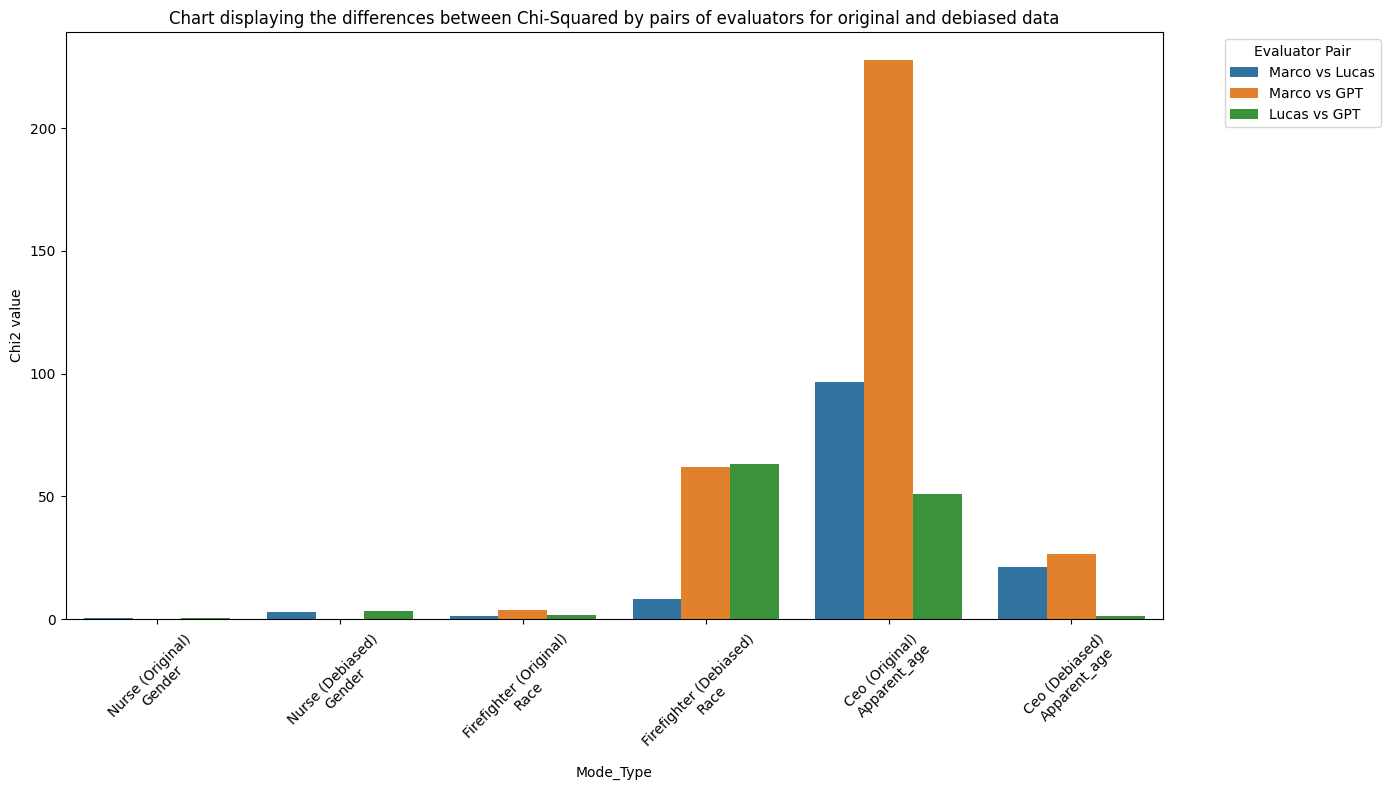

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming chi2_results is already available
# Create the Evaluator Pair column
chi2_results["Evaluator Pair"] = chi2_results["Evaluator 1"] + " vs " + chi2_results["Evaluator 2"]

# Create the Mode_Type column for combined Mode, Type, and Classification
chi2_results['Mode_Type'] = chi2_results['Mode'] + ' (' + chi2_results['Type'] + ') \n' + chi2_results['Classification']

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=chi2_results, x="Mode_Type", y="Chi2 Statistic", hue="Evaluator Pair")
plt.title("Chart displaying the differences between Chi-Squared by pairs of evaluators for original and debiased data")
plt.ylabel("Chi2 value")
plt.xticks(rotation=45)
plt.legend(title="Evaluator Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [93]:
chi2_results.columns

Index(['Mode', 'Type', 'Classification', 'Evaluator 1', 'Evaluator 2',
       'Chi2 Statistic', 'P-Value', 'Mode_Type', 'Evaluator Pair',
       'Bonferroni-Corrected P-Value'],
      dtype='object')

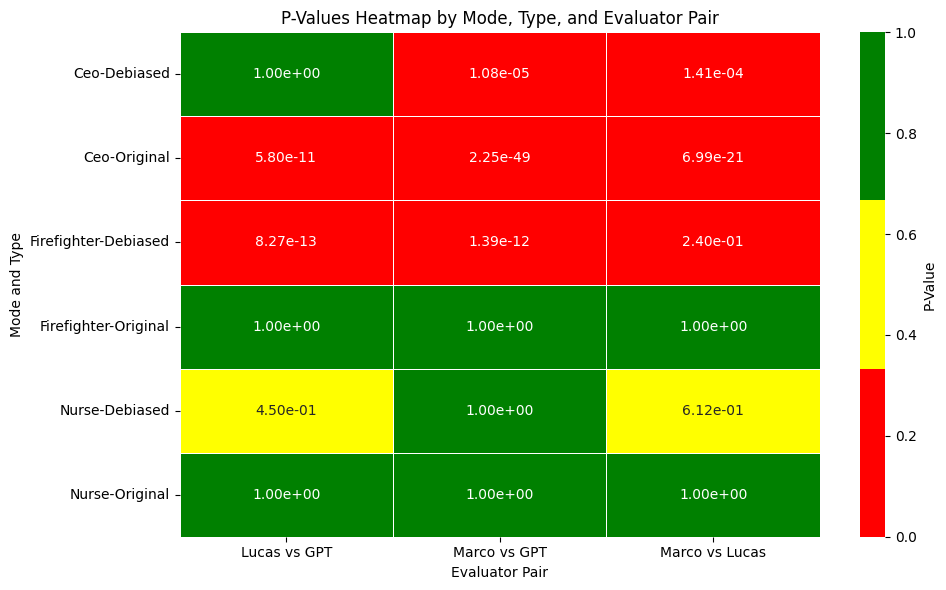

In [98]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import pandas as pd

# Example data (replace with your chi2_results pivot table)
p_values_pivot = chi2_results.pivot_table(
    values="Bonferroni-Corrected P-Value", 
    index=["Mode", "Type"], 
    columns="Evaluator Pair"
)

# Define custom boundaries and colors
boundaries = [0.0, 0.05, 0.1, 1.0]  # Ranges
colors = ["red", "yellow", "green"]  # Colors for each range

# Create the custom color map
custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_heatmap',
    colors=colors,
    N=len(boundaries) - 1
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    data=p_values_pivot,
    cmap=custom_color_map,
    vmin=0.0, vmax=1.0,  # Match the range of your P-Values
    annot=True,
    fmt=".2e",
    cbar_kws={'label': 'P-Value'},
    linewidths=0.5
)

plt.title("P-Values Heatmap by Mode, Type, and Evaluator Pair")
plt.xlabel("Evaluator Pair")
plt.ylabel("Mode and Type")Aimport seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.pyplot as plt
import pandas as pdA

# Example data (replace with your chi2_results pivot table)
p_values_pivot = chi2_results.pivot_table(
    values="Bonferroni-Corrected P-Value", 
    index=["Mode", "Type"], 
    columns="Evaluator Pair"
)

# Define custom boundaries and colors
boundaries = [0.0, 0.05, 0.1, 1.0]  # Ranges
colors = ["red", "yellow", "green"]  # Colors for each range

# Create a ListedColormap
custom_cmap = ListedColormap(colors)

# Create a BoundaryNorm to map the boundaries to the colormap
norm = BoundaryNorm(boundaries, ncolors=len(colors), clip=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    data=p_values_pivot,
    cmap=custom_cmap,
    norm=norm,  # Apply the BoundaryNorm
    annot=True,
    fmt=".2e",
    cbar_kws={'label': 'P-Value'},
    linewidths=0.5
)

plt.title("P-Values Heatmap by Mode, Type, and Evaluator Pair")
plt.xlabel("Evaluator Pair")
plt.ylabel("Mode and Type")
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


In [49]:
# Cohen's Kappa for original
print("Cohen's Kappa (Original):")
compute_cohens_kappa(df_marco[df_marco["type"] == "original"], 
                     df_lucas[df_lucas["type"] == "original"], 
                     "nurse", "gender", "marco", "lucas")

# Cohen's Kappa for debiased
print("Cohen's Kappa (Debiased):")
compute_cohens_kappa(df_marco[df_marco["type"] == "debiased"], 
                     df_lucas[df_lucas["type"] == "debiased"], 
                     "nurse", "gender", "marco", "lucas")

Cohen's Kappa (Original):


NameError: name 'compute_cohens_kappa' is not defined

## kappa cohen, 1v1

In [91]:
from sklearn.metrics import cohen_kappa_score

def compute_cohens_kappa(df1, df2, mode, classification, eval1, eval2):
    """
    Compute Cohen's Kappa between two evaluators for a specific mode and classification.

    Args:
        df1 (pd.DataFrame): First evaluator's dataframe.
        df2 (pd.DataFrame): Second evaluator's dataframe.
        mode (str): Mode to filter on (e.g., 'firefighter', 'nurse', 'ceo').
        classification (str): Column to compare (e.g., 'race', 'gender', 'apparent_age').
        eval1 (str): Name of the first evaluator.
        eval2 (str): Name of the second evaluator.

    Returns:
        float: Cohen's Kappa score.
    """
    # Filter both dataframes for the specific mode
    df1_mode = df1[df1["mode"] == mode]
    df2_mode = df2[df2["mode"] == mode]

    # Ensure both dataframes have the same 'id' for alignment
    merged = pd.merge(df1_mode[["id", classification]], 
                      df2_mode[["id", classification]], 
                      on="id", suffixes=(f"_{eval1}", f"_{eval2}"))
    
    # Compute Cohen's Kappa
    kappa = cohen_kappa_score(merged[f"{classification}_{eval1}"], merged[f"{classification}_{eval2}"])
    print(f"Cohen's Kappa ({eval1} vs {eval2}) for {mode.capitalize()} - {classification.capitalize()}: {kappa:.4f}")
    return kappa


In [94]:
# Firefighter - Race
print("Firefighter - Race:")
compute_cohens_kappa(df_marco, df_lucas, "firefighter", "race", "marco", "lucas")
compute_cohens_kappa(df_marco, gpt_firefighter_original, "firefighter", "race", "marco", "gpt")
compute_cohens_kappa(df_lucas, gpt_firefighter_original, "firefighter", "race", "lucas", "gpt")

# Nurse - Gender
print("\nNurse - Gender:")
compute_cohens_kappa(df_marco, df_lucas, "nurse", "gender", "marco", "lucas")
compute_cohens_kappa(df_marco, gpt_nurse_original, "nurse", "gender", "marco", "gpt")
compute_cohens_kappa(df_lucas, gpt_nurse_original, "nurse", "gender", "lucas", "gpt")

# CEO - Apparent Age
print("\nCEO - Apparent Age:")
compute_cohens_kappa(df_marco, df_lucas, "ceo", "apparent_age", "marco", "lucas")
compute_cohens_kappa(df_marco, gpt_ceo_original, "ceo", "apparent_age", "marco", "gpt")
compute_cohens_kappa(df_lucas, gpt_ceo_original, "ceo", "apparent_age", "lucas", "gpt")
print ('test')

Firefighter - Race:
Cohen's Kappa (marco vs lucas) for Firefighter - Race: 0.2417
Cohen's Kappa (marco vs gpt) for Firefighter - Race: 0.2072
Cohen's Kappa (lucas vs gpt) for Firefighter - Race: 0.2160

Nurse - Gender:
Cohen's Kappa (marco vs lucas) for Nurse - Gender: 0.0711
Cohen's Kappa (marco vs gpt) for Nurse - Gender: 0.0011
Cohen's Kappa (lucas vs gpt) for Nurse - Gender: 0.0018

CEO - Apparent Age:
Cohen's Kappa (marco vs lucas) for Ceo - Apparent_age: 0.0518
Cohen's Kappa (marco vs gpt) for Ceo - Apparent_age: 0.0111
Cohen's Kappa (lucas vs gpt) for Ceo - Apparent_age: 0.0278
test


## fleiss kappa, compare all

In [97]:
from statsmodels.stats.inter_rater import fleiss_kappa

def prepare_fleiss_kappa_matrix(dfs, mode, classification):
    """
    Prepare a matrix for Fleiss' Kappa calculation.

    Args:
        dfs (list): List of DataFrames (one per evaluator).
        mode (str): Mode to filter on (e.g., 'firefighter', 'nurse', 'ceo').
        classification (str): Column to analyze (e.g., 'race', 'gender', 'apparent_age').

    Returns:
        pd.DataFrame: Matrix for Fleiss' Kappa.
    """
    # Combine data from all evaluators for the specified mode
    combined = []
    for i, df in enumerate(dfs):
        df_mode = df[df["mode"] == mode][["id", classification]].copy()
        df_mode["evaluator"] = f"evaluator_{i+1}"
        combined.append(df_mode)
    
    combined_df = pd.concat(combined)
    
    # Pivot to create Fleiss' Kappa matrix
    kappa_matrix = combined_df.pivot_table(index="id", columns="evaluator", values=classification, aggfunc="first")
    kappa_matrix = pd.get_dummies(kappa_matrix.stack()).groupby(level=0).sum()  # One-hot encode and aggregate

    return kappa_matrix

def compute_fleiss_kappa(matrix, eval_label, mode, classification):
    """
    Compute Fleiss' Kappa for multiple evaluators.

    Args:
        matrix (pd.DataFrame): Fleiss' Kappa matrix.
        eval_label (str): Evaluation label for printout.
        mode (str): Mode being analyzed.
        classification (str): Classification being analyzed.

    Returns:
        float: Fleiss' Kappa score.
    """
    kappa = fleiss_kappa(matrix.values)
    print(f"Fleiss' Kappa ({eval_label}) for {mode.capitalize()} - {classification.capitalize()}: {kappa:.4f}")
    return kappa


In [125]:
!pip install krippendorff

In [138]:
from krippendorff import alpha
import numpy as np

def calculate_krippendorff_alpha(df1, df2, df3, classification, mode, data_type):
    """
    Calculates Krippendorff's Alpha for multiple evaluators.

    Args:
        df1, df2, df3 (pd.DataFrame): DataFrames for each evaluator.
        classification (str): Column to evaluate (e.g., 'race', 'gender').
        mode (str): Mode to filter (e.g., 'nurse', 'firefighter').
        data_type (str): Type to filter (e.g., 'original', 'debiased').

    Returns:
        float: Krippendorff's Alpha score.
    """
    # Filter DataFrames for the specified mode and type
    df1_filtered = df1[(df1["mode"] == mode) & (df1["type"] == data_type)]
    df2_filtered = df2[(df2["mode"] == mode) & (df2["type"] == data_type)]
    df3_filtered = df3  # Already filtered as GPT is split into original and debiased

    # Align IDs and prepare data
    merged = pd.merge(
        df1_filtered[['id', classification]].rename(columns={classification: "df1"}),
        df2_filtered[['id', classification]].rename(columns={classification: "df2"}),
        on="id"
    )
    merged = pd.merge(
        merged,
        df3_filtered[['id', classification]].rename(columns={classification: "df3"}),
        on="id"
    )

    # Prepare data for Krippendorff's Alpha
    data = merged[["df1", "df2", "df3"]].to_numpy()
    print(data)
    # Ensure all values are strings
    data = data.astype(str)

    # Calculate Krippendorff's Alpha
    try:
        alpha_value = alpha(reliability_data=data, level_of_measurement='nominal')
        print(f"Krippendorff's Alpha ({mode.capitalize()} - {classification.capitalize()} - {data_type.capitalize()}): {alpha_value:.4f}")
        return alpha_value
    except ValueError as e:
        print(f"Error calculating Krippendorff's Alpha: {e}")
        return None

# Exemplo: Comparar Marco, Lucas e GPT para Nurse - Gender (Original)
result = calculate_krippendorff_alpha(
    df_marco,
    df_lucas,
    gpt_firefighter_debiased,  # Already filtered for original
    "race",
    "firefighter",
    "debiased"
)


[['indian' 'indian' 'indian']
 ['black' 'black' 'black']
 ['indian' 'indian' 'white']
 ['black' 'indian' 'black']
 ['indian' 'indian' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'white']
 ['indian' 'white' 'black']
 ['black' 'white' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'indian']
 ['black' 'black' 'black']
 ['black' 'white' 'white']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['indian' 'white' 'black']
 ['asian' 'white' 'white']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'indian' 'black']
 ['indian' 'indian' 'black']
 ['indian' 'indian' 'black']
 ['indian' 'white' 'white']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'indian']
 ['black' 'black' 'black']
 ['indian' 'indian' 'asian']
 ['black' 'black' 'black']
 ['white' 'white' 'white']


In [98]:
# Prepare matrix for Firefighter - Race
firefighter_matrix = prepare_fleiss_kappa_matrix(
    [df_marco, df_lucas, gpt_firefighter_original], "firefighter", "race"
)
compute_fleiss_kappa(firefighter_matrix, "Firefighter", "firefighter", "race")

# Prepare matrix for Nurse - Gender
nurse_matrix = prepare_fleiss_kappa_matrix(
    [df_marco, df_lucas, gpt_nurse_original], "nurse", "gender"
)
compute_fleiss_kappa(nurse_matrix, "Nurse", "nurse", "gender")

# Prepare matrix for CEO - Apparent Age
ceo_matrix = prepare_fleiss_kappa_matrix(
    [df_marco, df_lucas, gpt_ceo_original], "ceo", "apparent_age"
)
compute_fleiss_kappa(ceo_matrix, "CEO", "ceo", "apparent_age")


Fleiss' Kappa (Firefighter) for Firefighter - Race: 0.2549
Fleiss' Kappa (Nurse) for Nurse - Gender: -0.0364
Fleiss' Kappa (CEO) for Ceo - Apparent_age: -0.0922


-0.0921908797165824